<a href="https://www.kaggle.com/code/ayushs9020/understanding-the-competition-icr-eda?scriptVersionId=130048313" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# ICR Identify Age Related Conditions 

$ICR$, or $Identify$ $Age$ $Related$ $Conditions$, is a process aimed at `detecting and diagnosing health conditions commonly associated with aging`. It involves a `comprehensive evaluation` of an individual's `medical history`, `physical examination`, and `specific tests` to assess their overall health and `identify` any `age-related conditions`. The `goal` is to `catch potential issues early` on, allowing for `timely intervention` and `management of age-related health concerns`. $ICR$ helps healthcare professionals tailor `preventive measures` and `develop personalized` treatment plans to promote `healthy aging`.

<img src = "https://www.care.com/c/wp-content/uploads/sites/2/2021/03/getting-old-realize-meme.jpg.optimal.jpg">

# 1 | Important Points 📃
* This is a **`binary classification`** problem where $1$ is for `suffering from a disease` and $0$ is for `not suffering from any disease`.

* * The class $1$ is further divided into $3$ more categoreis, we actually do not know much about the actual names of these categories, but according to the data, these are 

* * * **B**
* * * **D**
* * * **G**

* * Though we are actually not given $1$ or $0$. Rather values like $(A , B , D , G)$

* Using $XGBoost$ and $RandomForestClassifier$ and more of such algorithms, `may give better results`, but might **not be actually benificial for the actual purpose of the competition and research**. As it is written that they have been using these algorithms from the year they were established ie $2015$. Try to come up with something different

# 2 | Advisory 🚀
## Greeks
* `Id` - It is like the primary of the data, you can probably remove that one
* `Alpha` - Change the values corresponding to `A` to $0$ , and rest to be $0$. The data is highly imbalanced, having $(0 -> 82.50)$ and $(1 -> 17.50)$. I recomend using `Random Over Sampling`.

```
from imblearn_oversampling import RandomOverSampler

features , target = RandomOverSampler().fit_resample(features , target)
```

* `Beta` - This is the first experimental characteristic, This further contains $3$ values $(A , B , C)$, but the ratio of $(A)$ is really small, At this point I have decided to assume $(A)$ as $(B)$, but we do not have any actual reason for doing so. $(A -> 1.30, B -> 32.74, C -> 67.96)$
* `Gamma` - This is the second experimental characteristic, This further contains $8$ values $(A , B , E , F , G , H , M , N)$ , but the combined ratio of $(A , B , E , F , G)$ is around $8.92$% , which is just above than their succesor $(H)$ with $8.59$%. Combining these into $1$ might give better performance. $(A ->1.30, B ->1.30, E ->1.62, F ->1.78, G ->2.92, H ->8.59, M ->10.37, N ->72.12)$. At this point I have converted these into $(G)$. There was no particular reason for converting these into $(G)$ only. 
* `Delta` - This is the third experimental characteristic. This further contains $4$ values $(A , B , C , D)$. These are in good condtion with $(A ->73.91, B ->12.16, C ->10.37, D ->3.57)$
* `Epsilon` - Though you can use this `feature` with some preprocessing, but it might not be good to classify someone with a disease on the basis of the date the person came. That is indirectly racism on date!! . 

In [1]:
import numpy as np 
import pandas as pd

In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from sklearn.preprocessing import StandardScaler 

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [5]:
from sklearn.metrics import classification_report 

In [6]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense 

In [7]:
import tensorflow_addons as tfa

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [8]:
! pip install wandb

In [9]:
import wandb
from wandb.keras import WandbCallback

In [10]:
import tqdm

In [11]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
api = user_secrets.get_secret("API LOGIN KEY")

In [12]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


In [13]:
wandb.login(key = api)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Lets take a look at the datasets now
# 3 | Data Analysis
# 3.1 | Greeks 🔠
**Supplemental metadata, only available for the training set**.

In [14]:
greeks = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")
greeks

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020
...,...,...,...,...,...,...
612,fd3dafe738fd,A,B,M,B,9/13/2020
613,fd895603f071,A,B,M,B,9/8/2020
614,fd8ef6377f76,A,C,M,B,7/24/2019
615,fe1942975e40,A,C,M,B,1/31/2019


In [15]:
greeks.drop("Id" , axis = 1 , inplace = True)
greeks

,Alpha,Beta,Gamma,Delta,Epsilon
0,B,C,G,D,3/19/2019
1,A,C,M,B,Unknown
2,A,C,M,B,Unknown
3,A,C,M,B,Unknown
4,D,B,F,B,3/25/2020
...,...,...,...,...,...
612,A,B,M,B,9/13/2020
613,A,B,M,B,9/8/2020
614,A,C,M,B,7/24/2019
615,A,C,M,B,1/31/2019


<AxesSubplot: ylabel='Alpha'>

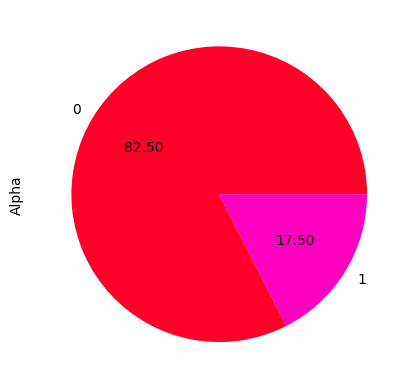

In [16]:
greeks["Alpha"] = np.where(greeks["Alpha"] == "A" , 0 , 1)
greeks["Alpha"].value_counts().plot(kind = "pie" , autopct = "%.2f" , cmap = "gist_rainbow")

<AxesSubplot: ylabel='Beta'>

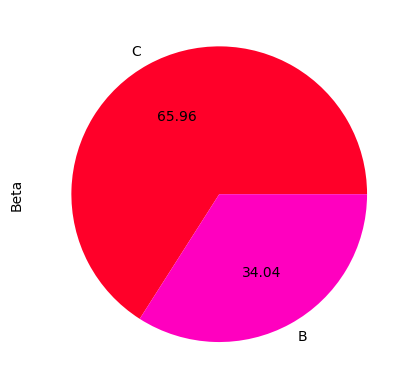

In [17]:
greeks["Beta"] = np.where(greeks["Beta"] == "A" , "B" , greeks["Beta"])
greeks["Beta"].value_counts().plot(kind = "pie" , autopct = "%.2f" , cmap = "gist_rainbow")

<AxesSubplot: ylabel='Gamma'>

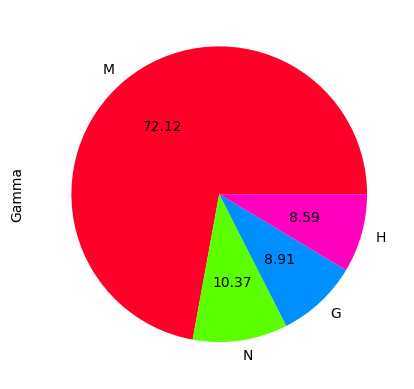

In [18]:
greeks["Gamma"] = np.where(greeks["Gamma"] == "A" , "G" , greeks["Gamma"])
greeks["Gamma"] = np.where(greeks["Gamma"] == "B" , "G" , greeks["Gamma"])
greeks["Gamma"] = np.where(greeks["Gamma"] == "E" , "G" , greeks["Gamma"])
greeks["Gamma"] = np.where(greeks["Gamma"] == "F" , "G" , greeks["Gamma"])
greeks["Gamma"].value_counts().plot(kind = "pie" , autopct = "%.2f" , cmap = "gist_rainbow")

<AxesSubplot: ylabel='Delta'>

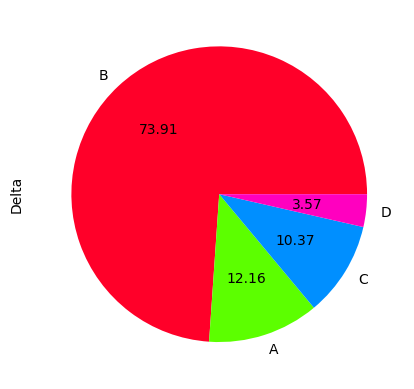

In [19]:
greeks["Delta"].value_counts().plot(kind = "pie" , autopct = "%.2f" , cmap = "gist_rainbow")

# 3.2 | Train 🚅

In [20]:
data = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
data

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0
615,fe1942975e40,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0


This is how `training data` looks like. We can train different binary classification algorithm on this data. `Id` column for this data as well is just the primary key for the data, and thus can be removed. You actually dont need the `supplement metdata` for this competition in the training. As the testing data do not contain those columns. Those are just for `training data ` 

We have $617$ rows and $58$ columns accounting to $36,784$ values. This is a big data to work upon

Lets get more information about the data. 

**As there are $58$ columns, I might hide output cells in many cases to save spaces. You can still see the whole picture by clikcing on the `show output cell` button just below the code cell**

In [21]:
data.drop("Id" , axis = 1 , inplace = True)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AB      617 non-null    float64
 1   AF      617 non-null    float64
 2   AH      617 non-null    float64
 3   AM      617 non-null    float64
 4   AR      617 non-null    float64
 5   AX      617 non-null    float64
 6   AY      617 non-null    float64
 7   AZ      617 non-null    float64
 8   BC      617 non-null    float64
 9   BD      617 non-null    float64
 10  BN      617 non-null    float64
 11  BP      617 non-null    float64
 12  BQ      557 non-null    float64
 13  BR      617 non-null    float64
 14  BZ      617 non-null    float64
 15  CB      615 non-null    float64
 16  CC      614 non-null    float64
 17  CD      617 non-null    float64
 18  CF      617 non-null    float64
 19  CH      617 non-null    float64
 20  CL      617 non-null    float64
 21  CR      617 non-null    float64
 22  CS

As we can see there is a column named `EJ` which is categorical. Categorical is basically something that is in the `str` format. We cannot send `str` data into any model. So we will convert this into somekind of `numercial` data 

<AxesSubplot: ylabel='EJ'>

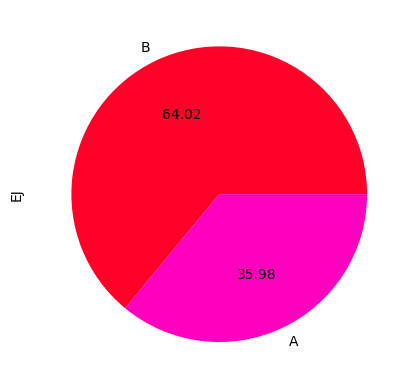

In [23]:
data["EJ"].value_counts().plot(kind = "pie" , autopct = "%.2f" , cmap = "gist_rainbow")

In [24]:
data["EJ"] = np.where(data["EJ"] == "A" , 1 , 0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AB      617 non-null    float64
 1   AF      617 non-null    float64
 2   AH      617 non-null    float64
 3   AM      617 non-null    float64
 4   AR      617 non-null    float64
 5   AX      617 non-null    float64
 6   AY      617 non-null    float64
 7   AZ      617 non-null    float64
 8   BC      617 non-null    float64
 9   BD      617 non-null    float64
 10  BN      617 non-null    float64
 11  BP      617 non-null    float64
 12  BQ      557 non-null    float64
 13  BR      617 non-null    float64
 14  BZ      617 non-null    float64
 15  CB      615 non-null    float64
 16  CC      614 non-null    float64
 17  CD      617 non-null    float64
 18  CF      617 non-null    float64
 19  CH      617 non-null    float64
 20  CL      617 non-null    float64
 21  CR      617 non-null    float64
 22  CS

Now lets check if the data has null values...

In [25]:
for feature in data.columns:
    if data[feature].isnull().any():
        print(feature , True)

BQ True
CB True
CC True
DU True
EL True
FC True
FL True
FS True
GL True


So these columns have `null/nan`, we cannot send `null` values into models. We need to change them with some values. One way is to change them with `mean values`

In [26]:
for feature in data.columns:
    if data[feature].isnull().any():
        data[feature].fillna(value = data[feature].mean() , axis = 0 , inplace = True)

In [27]:
for feature in data.columns:
    if data[feature].isnull().any():
        print(feature , True)

And now there is no null values in the data 

# 3.3 | Test 🧪

In [28]:
test = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")
test

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


And this is our testing data. Yes it only contains $5$ rows 
# 4 | Model Building 🤖

To ensure that all features contribute equally to the model.

Features with different scales can have a disproportionate impact on the model, leading to inaccurate results. Scaling ensures that all features are on a similar scale, so that the model can learn from them equally.

Here we will be using **[sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)**, but for getting into deep how the scaler works, below is the code for you and here is the notebook containing the **[explanation](https://www.kaggle.com/code/ayushs9020/scaling-techniques-from-scratch)**

```
! pip install numpy 

import numpy as np 

def standard_scaler(array , copy = True):
    if copy:
        
        y = np.empty(shape = array.shape)
        
        for i,j in enumerate(array):
            
            y[i] = (j - array.mean()) / (array.std())
        
        return y
    
    else :
        
        for i,j in enumerate(array):
            
            array[i] = (j - array.mean()) / (array.std())
        
        return array
```

In [29]:
train , val = np.split(data.sample(frac = 1) , [int(len(data) * 0.8)])

In [30]:
def pre(dataframe):
    X = dataframe.drop("Class" , axis = 1)
    y = dataframe["Class"]
    
    return X , y

In [31]:
X_train , y_train = pre(train)
X_val , y_val = pre(val)

# 5.1 | K Nearest Neighbors 🚗

K Nearest Neighbors (KNN) is a supervised machine learning algorithm that can be used for both classification and regression problems. It works by finding the k most similar data points to a new data point and then assigning the new data point to the class of the majority of the k nearest neighbors.

<img src = "https://media.geeksforgeeks.org/wp-content/uploads/20200616145419/Untitled2781.png">

If you want to know more about `KNN` here is the code for you, and here is the notebook with the **[explanation](https://www.kaggle.com/code/ayushs9020/knn-from-scratch)**

```
! pip install collections
! pip install numpy

from collections import Counter
import numpy as np 

def KNN(X_train , y_train , X_test):
    
    distance = [0] * X_train.shape[0]
    
    for columns in X_train.columns:
        
        for index in range(len(X_train[columns])):
            
            distance[index] += X_train[columns][index] - X_test[columns][index]
    
    distance = np.sqrt(np.array(distance))
    
    return Counter(y_test[np.argsort(distance)[:3]]).most_common()[0][0]
```

<img src = "https://www.mihaileric.com/static/knn-meme-d997d3c26b3769fc03492b12819c6223-d90b6.jpg">

In [32]:
KNN = KNeighborsClassifier()
KNN.fit(X_train , y_train)

KNeighborsClassifier()

# 5.2 | Logistic Regression 

Logistic regression is a statistical model that is used to predict the probability of an event occurring. It is a type of regression analysis that uses a logistic function to model the probability of a binary outcome. The logistic function is a sigmoid function that maps real numbers to the interval $(0, 1)$. This means that the output of the logistic function can be interpreted as the probability of an event occurring.

<img src = "https://miro.medium.com/v2/resize:fit:800/1*is3vZACPepjNVWf-j6kUgA.jpeg">

In [33]:
LR = LogisticRegression()
LR.fit(X_train , y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

<img src = "https://www.mihaileric.com/static/logistic_regression_meme-dc70fd90996941296fb922886a138053-ed51e.jpg">

# 7 | Neural Networks 

eural networks are a type of machine learning algorithm inspired by the human brain. They are made up of layers of interconnected nodes, and they learn to perform tasks by adjusting the weights of the connections between these nodes. Neural networks have been used to achieve state-of-the-art results in a wide range of tasks, including image classification, natural language processing, and speech recognition.

<img src = "https://media.makeameme.org/created/neural-networks-neural.jpg">

In [34]:
NN = Sequential() 

NN.add(Dense(56 , activation = "sigmoid" , input_dim = 56))
NN.add(Dense(50 , activation = "sigmoid" , input_dim = 56))
NN.add(Dense(40 , activation = "sigmoid" , input_dim = 50))
NN.add(Dense(30 , activation = "sigmoid" , input_dim = 40))
NN.add(Dense(20 , activation = "sigmoid" , input_dim = 30))
NN.add(Dense(10 , activation = "sigmoid" , input_dim = 20))

NN.add(Dense(1 , activation = "sigmoid" , input_dim = 10))

In [35]:
NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 56)                3192      
                                                                 
 dense_1 (Dense)             (None, 50)                2850      
                                                                 
 dense_2 (Dense)             (None, 40)                2040      
                                                                 
 dense_3 (Dense)             (None, 30)                1230      
                                                                 
 dense_4 (Dense)             (None, 20)                620       
                                                                 
 dense_5 (Dense)             (None, 10)                210       
                                                                 
 dense_6 (Dense)             (None, 1)                 1

In [36]:
NN.compile(loss = "binary_crossentropy" , optimizer = "Adam" , metrics = ["accuracy"])

In [37]:
run = wandb.init(project  = "ICR Identify Age Related Conditions" , 
                config = {"learning_rate" : 0.005 , 
                         "epochs" : 100 , 
                         "batch_size" : 3 , 
                         "loss_function" : "accuracy" , 
                         "architechture" : "ANN" , 
                         "dataset" : "ICR"}) 

wandb: Currently logged in as: ayushsinghal659. Use `wandb login --relogin` to force relogin


In [38]:
config = wandb.config

In [39]:
tqdm_callback = tfa.callbacks.TQDMProgressBar()

In [40]:
sample_fit = NN.fit(X_train , y_train , epochs = config.epochs , batch_size = config.batch_size , validation_split = 0.2 , callbacks = [WandbCallback() , tqdm_callback])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Training:   0%|           0/100 ETA: ?s,  ?epochs/s

Epoch 1/100


0/132           ETA: ?s - 

Epoch 1/100
111/132 [========================>.....] - ETA: 0s - loss: 0.6450 - accuracy: 0.6396

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230518_113051-xoho2gfa/files/model-best)... Done. 0.0s


132/132 [==============================] - 4s 16ms/step - loss: 0.6243 - accuracy: 0.6675 - val_loss: 0.5133 - val_accuracy: 0.8081
Epoch 2/100


0/132           ETA: ?s - 

Epoch 2/100
120/132 [==========================>...] - ETA: 0s - loss: 0.4711 - accuracy: 0.8333

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230518_113051-xoho2gfa/files/model-best)... Done. 0.0s


132/132 [==============================] - 2s 13ms/step - loss: 0.4711 - accuracy: 0.8325 - val_loss: 0.4907 - val_accuracy: 0.8081
Epoch 3/100


0/132           ETA: ?s - 

Epoch 3/100
111/132 [========================>.....] - ETA: 0s - loss: 0.4702 - accuracy: 0.8228

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230518_113051-xoho2gfa/files/model-best)... Done. 0.0s


132/132 [==============================] - 2s 15ms/step - loss: 0.4562 - accuracy: 0.8325 - val_loss: 0.4890 - val_accuracy: 0.8081
Epoch 4/100


0/132           ETA: ?s - 

Epoch 4/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4530 - accuracy: 0.8325 - val_loss: 0.4900 - val_accuracy: 0.8081
Epoch 5/100


0/132           ETA: ?s - 

Epoch 5/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4525 - accuracy: 0.8325 - val_loss: 0.4906 - val_accuracy: 0.8081
Epoch 6/100


0/132           ETA: ?s - 

Epoch 6/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4529 - accuracy: 0.8325 - val_loss: 0.4910 - val_accuracy: 0.8081
Epoch 7/100


0/132           ETA: ?s - 

Epoch 7/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4525 - accuracy: 0.8325 - val_loss: 0.4904 - val_accuracy: 0.8081
Epoch 8/100


0/132           ETA: ?s - 

Epoch 8/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4524 - accuracy: 0.8325 - val_loss: 0.4909 - val_accuracy: 0.8081
Epoch 9/100


0/132           ETA: ?s - 

Epoch 9/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4525 - accuracy: 0.8325 - val_loss: 0.4912 - val_accuracy: 0.8081
Epoch 10/100


0/132           ETA: ?s - 

Epoch 10/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4524 - accuracy: 0.8325 - val_loss: 0.4907 - val_accuracy: 0.8081
Epoch 11/100


0/132           ETA: ?s - 

Epoch 11/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4522 - accuracy: 0.8325 - val_loss: 0.4907 - val_accuracy: 0.8081
Epoch 12/100


0/132           ETA: ?s - 

Epoch 12/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4513 - accuracy: 0.8325 - val_loss: 0.4896 - val_accuracy: 0.8081
Epoch 13/100


0/132           ETA: ?s - 

Epoch 13/100
126/132 [===========================>..] - ETA: 0s - loss: 0.4442 - accuracy: 0.8360

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230518_113051-xoho2gfa/files/model-best)... Done. 0.0s


132/132 [==============================] - 2s 12ms/step - loss: 0.4496 - accuracy: 0.8325 - val_loss: 0.4833 - val_accuracy: 0.8081
Epoch 14/100


0/132           ETA: ?s - 

Epoch 14/100
120/132 [==========================>...] - ETA: 0s - loss: 0.4258 - accuracy: 0.8444

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230518_113051-xoho2gfa/files/model-best)... Done. 0.0s


132/132 [==============================] - 2s 13ms/step - loss: 0.4435 - accuracy: 0.8325 - val_loss: 0.4771 - val_accuracy: 0.8081
Epoch 15/100


0/132           ETA: ?s - 

Epoch 15/100
115/132 [=========================>....] - ETA: 0s - loss: 0.4499 - accuracy: 0.8232

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230518_113051-xoho2gfa/files/model-best)... Done. 0.0s


132/132 [==============================] - 2s 13ms/step - loss: 0.4362 - accuracy: 0.8325 - val_loss: 0.4749 - val_accuracy: 0.8081
Epoch 16/100


0/132           ETA: ?s - 

Epoch 16/100
114/132 [========================>.....] - ETA: 0s - loss: 0.4223 - accuracy: 0.8363

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230518_113051-xoho2gfa/files/model-best)... Done. 0.0s


132/132 [==============================] - 2s 13ms/step - loss: 0.4262 - accuracy: 0.8325 - val_loss: 0.4724 - val_accuracy: 0.8081
Epoch 17/100


0/132           ETA: ?s - 

Epoch 17/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4236 - accuracy: 0.8325 - val_loss: 0.4810 - val_accuracy: 0.8081
Epoch 18/100


0/132           ETA: ?s - 

Epoch 18/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4169 - accuracy: 0.8325 - val_loss: 0.4876 - val_accuracy: 0.8081
Epoch 19/100


0/132           ETA: ?s - 

Epoch 19/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4128 - accuracy: 0.8579 - val_loss: 0.4894 - val_accuracy: 0.7980
Epoch 20/100


0/132           ETA: ?s - 

Epoch 20/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4086 - accuracy: 0.8629 - val_loss: 0.4915 - val_accuracy: 0.7980
Epoch 21/100


0/132           ETA: ?s - 

Epoch 21/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4063 - accuracy: 0.8629 - val_loss: 0.4940 - val_accuracy: 0.7980
Epoch 22/100


0/132           ETA: ?s - 

Epoch 22/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4030 - accuracy: 0.8629 - val_loss: 0.4999 - val_accuracy: 0.7980
Epoch 23/100


0/132           ETA: ?s - 

Epoch 23/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4025 - accuracy: 0.8629 - val_loss: 0.4976 - val_accuracy: 0.7980
Epoch 24/100


0/132           ETA: ?s - 

Epoch 24/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4010 - accuracy: 0.8629 - val_loss: 0.5058 - val_accuracy: 0.7980
Epoch 25/100


0/132           ETA: ?s - 

Epoch 25/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3993 - accuracy: 0.8629 - val_loss: 0.4983 - val_accuracy: 0.7980
Epoch 26/100


0/132           ETA: ?s - 

Epoch 26/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4006 - accuracy: 0.8629 - val_loss: 0.5043 - val_accuracy: 0.7980
Epoch 27/100


0/132           ETA: ?s - 

Epoch 27/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3983 - accuracy: 0.8655 - val_loss: 0.5133 - val_accuracy: 0.7980
Epoch 28/100


0/132           ETA: ?s - 

Epoch 28/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3993 - accuracy: 0.8629 - val_loss: 0.5140 - val_accuracy: 0.7980
Epoch 29/100


0/132           ETA: ?s - 

Epoch 29/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3970 - accuracy: 0.8655 - val_loss: 0.5179 - val_accuracy: 0.7980
Epoch 30/100


0/132           ETA: ?s - 

Epoch 30/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3969 - accuracy: 0.8655 - val_loss: 0.5189 - val_accuracy: 0.7980
Epoch 31/100


0/132           ETA: ?s - 

Epoch 31/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3959 - accuracy: 0.8655 - val_loss: 0.5179 - val_accuracy: 0.7980
Epoch 32/100


0/132           ETA: ?s - 

Epoch 32/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3955 - accuracy: 0.8655 - val_loss: 0.5211 - val_accuracy: 0.7980
Epoch 33/100


0/132           ETA: ?s - 

Epoch 33/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3950 - accuracy: 0.8655 - val_loss: 0.5242 - val_accuracy: 0.7980
Epoch 34/100


0/132           ETA: ?s - 

Epoch 34/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3953 - accuracy: 0.8655 - val_loss: 0.5272 - val_accuracy: 0.7980
Epoch 35/100


0/132           ETA: ?s - 

Epoch 35/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3954 - accuracy: 0.8655 - val_loss: 0.5273 - val_accuracy: 0.7980
Epoch 36/100


0/132           ETA: ?s - 

Epoch 36/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3960 - accuracy: 0.8655 - val_loss: 0.5298 - val_accuracy: 0.7980
Epoch 37/100


0/132           ETA: ?s - 

Epoch 37/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3953 - accuracy: 0.8655 - val_loss: 0.5306 - val_accuracy: 0.7980
Epoch 38/100


0/132           ETA: ?s - 

Epoch 38/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3950 - accuracy: 0.8655 - val_loss: 0.5307 - val_accuracy: 0.7980
Epoch 39/100


0/132           ETA: ?s - 

Epoch 39/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3951 - accuracy: 0.8655 - val_loss: 0.5322 - val_accuracy: 0.7980
Epoch 40/100


0/132           ETA: ?s - 

Epoch 40/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3949 - accuracy: 0.8655 - val_loss: 0.5324 - val_accuracy: 0.7980
Epoch 41/100


0/132           ETA: ?s - 

Epoch 41/100
132/132 [==============================] - 0s 2ms/step - loss: 0.3951 - accuracy: 0.8655 - val_loss: 0.5338 - val_accuracy: 0.7980
Epoch 42/100


0/132           ETA: ?s - 

Epoch 42/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3951 - accuracy: 0.8655 - val_loss: 0.5345 - val_accuracy: 0.7980
Epoch 43/100


0/132           ETA: ?s - 

Epoch 43/100
132/132 [==============================] - 0s 2ms/step - loss: 0.3954 - accuracy: 0.8655 - val_loss: 0.5314 - val_accuracy: 0.7980
Epoch 44/100


0/132           ETA: ?s - 

Epoch 44/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3950 - accuracy: 0.8655 - val_loss: 0.5344 - val_accuracy: 0.7980
Epoch 45/100


0/132           ETA: ?s - 

Epoch 45/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3946 - accuracy: 0.8655 - val_loss: 0.5356 - val_accuracy: 0.7980
Epoch 46/100


0/132           ETA: ?s - 

Epoch 46/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3957 - accuracy: 0.8655 - val_loss: 0.5202 - val_accuracy: 0.7980
Epoch 47/100


0/132           ETA: ?s - 

Epoch 47/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3952 - accuracy: 0.8655 - val_loss: 0.5370 - val_accuracy: 0.7980
Epoch 48/100


0/132           ETA: ?s - 

Epoch 48/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3951 - accuracy: 0.8655 - val_loss: 0.5362 - val_accuracy: 0.7980
Epoch 49/100


0/132           ETA: ?s - 

Epoch 49/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4000 - accuracy: 0.8629 - val_loss: 0.5231 - val_accuracy: 0.7980
Epoch 50/100


0/132           ETA: ?s - 

Epoch 50/100
132/132 [==============================] - 0s 3ms/step - loss: 0.4023 - accuracy: 0.8629 - val_loss: 0.5340 - val_accuracy: 0.7980
Epoch 51/100


0/132           ETA: ?s - 

Epoch 51/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3956 - accuracy: 0.8655 - val_loss: 0.5312 - val_accuracy: 0.7980
Epoch 52/100


0/132           ETA: ?s - 

Epoch 52/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3951 - accuracy: 0.8655 - val_loss: 0.5323 - val_accuracy: 0.7980
Epoch 53/100


0/132           ETA: ?s - 

Epoch 53/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3943 - accuracy: 0.8655 - val_loss: 0.5327 - val_accuracy: 0.7980
Epoch 54/100


0/132           ETA: ?s - 

Epoch 54/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3938 - accuracy: 0.8655 - val_loss: 0.5242 - val_accuracy: 0.7980
Epoch 55/100


0/132           ETA: ?s - 

Epoch 55/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3970 - accuracy: 0.8629 - val_loss: 0.5193 - val_accuracy: 0.8081
Epoch 56/100


0/132           ETA: ?s - 

Epoch 56/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3904 - accuracy: 0.8680 - val_loss: 0.5235 - val_accuracy: 0.7980
Epoch 57/100


0/132           ETA: ?s - 

Epoch 57/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3891 - accuracy: 0.8680 - val_loss: 0.5174 - val_accuracy: 0.8081
Epoch 58/100


0/132           ETA: ?s - 

Epoch 58/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3901 - accuracy: 0.8680 - val_loss: 0.5198 - val_accuracy: 0.8081
Epoch 59/100


0/132           ETA: ?s - 

Epoch 59/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3890 - accuracy: 0.8680 - val_loss: 0.5172 - val_accuracy: 0.8081
Epoch 60/100


0/132           ETA: ?s - 

Epoch 60/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3885 - accuracy: 0.8655 - val_loss: 0.5176 - val_accuracy: 0.8081
Epoch 61/100


0/132           ETA: ?s - 

Epoch 61/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3900 - accuracy: 0.8680 - val_loss: 0.5178 - val_accuracy: 0.8081
Epoch 62/100


0/132           ETA: ?s - 

Epoch 62/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3906 - accuracy: 0.8680 - val_loss: 0.5259 - val_accuracy: 0.7980
Epoch 63/100


0/132           ETA: ?s - 

Epoch 63/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3884 - accuracy: 0.8680 - val_loss: 0.5183 - val_accuracy: 0.8081
Epoch 64/100


0/132           ETA: ?s - 

Epoch 64/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3912 - accuracy: 0.8655 - val_loss: 0.5177 - val_accuracy: 0.8081
Epoch 65/100


0/132           ETA: ?s - 

Epoch 65/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3881 - accuracy: 0.8680 - val_loss: 0.5226 - val_accuracy: 0.7980
Epoch 66/100


0/132           ETA: ?s - 

Epoch 66/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3898 - accuracy: 0.8655 - val_loss: 0.5279 - val_accuracy: 0.7980
Epoch 67/100


0/132           ETA: ?s - 

Epoch 67/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3869 - accuracy: 0.8706 - val_loss: 0.5201 - val_accuracy: 0.8081
Epoch 68/100


0/132           ETA: ?s - 

Epoch 68/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3921 - accuracy: 0.8655 - val_loss: 0.5186 - val_accuracy: 0.8081
Epoch 69/100


0/132           ETA: ?s - 

Epoch 69/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3890 - accuracy: 0.8680 - val_loss: 0.5231 - val_accuracy: 0.7980
Epoch 70/100


0/132           ETA: ?s - 

Epoch 70/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3867 - accuracy: 0.8706 - val_loss: 0.5296 - val_accuracy: 0.7980
Epoch 71/100


0/132           ETA: ?s - 

Epoch 71/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3882 - accuracy: 0.8655 - val_loss: 0.5277 - val_accuracy: 0.7980
Epoch 72/100


0/132           ETA: ?s - 

Epoch 72/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3862 - accuracy: 0.8706 - val_loss: 0.5214 - val_accuracy: 0.8081
Epoch 73/100


0/132           ETA: ?s - 

Epoch 73/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3856 - accuracy: 0.8706 - val_loss: 0.5264 - val_accuracy: 0.7980
Epoch 74/100


0/132           ETA: ?s - 

Epoch 74/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3852 - accuracy: 0.8706 - val_loss: 0.5260 - val_accuracy: 0.8081
Epoch 75/100


0/132           ETA: ?s - 

Epoch 75/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3851 - accuracy: 0.8706 - val_loss: 0.5259 - val_accuracy: 0.8081
Epoch 76/100


0/132           ETA: ?s - 

Epoch 76/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3847 - accuracy: 0.8706 - val_loss: 0.5264 - val_accuracy: 0.8081
Epoch 77/100


0/132           ETA: ?s - 

Epoch 77/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3855 - accuracy: 0.8706 - val_loss: 0.5249 - val_accuracy: 0.8081
Epoch 78/100


0/132           ETA: ?s - 

Epoch 78/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3851 - accuracy: 0.8706 - val_loss: 0.5288 - val_accuracy: 0.7980
Epoch 79/100


0/132           ETA: ?s - 

Epoch 79/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3848 - accuracy: 0.8706 - val_loss: 0.5253 - val_accuracy: 0.8081
Epoch 80/100


0/132           ETA: ?s - 

Epoch 80/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3848 - accuracy: 0.8706 - val_loss: 0.5260 - val_accuracy: 0.8081
Epoch 81/100


0/132           ETA: ?s - 

Epoch 81/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3845 - accuracy: 0.8706 - val_loss: 0.5249 - val_accuracy: 0.7980
Epoch 82/100


0/132           ETA: ?s - 

Epoch 82/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3879 - accuracy: 0.8680 - val_loss: 0.5252 - val_accuracy: 0.8081
Epoch 83/100


0/132           ETA: ?s - 

Epoch 83/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3847 - accuracy: 0.8706 - val_loss: 0.5256 - val_accuracy: 0.8081
Epoch 84/100


0/132           ETA: ?s - 

Epoch 84/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3848 - accuracy: 0.8706 - val_loss: 0.5251 - val_accuracy: 0.8081
Epoch 85/100


0/132           ETA: ?s - 

Epoch 85/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3847 - accuracy: 0.8706 - val_loss: 0.5238 - val_accuracy: 0.8081
Epoch 86/100


0/132           ETA: ?s - 

Epoch 86/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3850 - accuracy: 0.8706 - val_loss: 0.5220 - val_accuracy: 0.8081
Epoch 87/100


0/132           ETA: ?s - 

Epoch 87/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3847 - accuracy: 0.8706 - val_loss: 0.5233 - val_accuracy: 0.8081
Epoch 88/100


0/132           ETA: ?s - 

Epoch 88/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3929 - accuracy: 0.8629 - val_loss: 0.5042 - val_accuracy: 0.8081
Epoch 89/100


0/132           ETA: ?s - 

Epoch 89/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3863 - accuracy: 0.8680 - val_loss: 0.5223 - val_accuracy: 0.8081
Epoch 90/100


0/132           ETA: ?s - 

Epoch 90/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3901 - accuracy: 0.8680 - val_loss: 0.5281 - val_accuracy: 0.7980
Epoch 91/100


0/132           ETA: ?s - 

Epoch 91/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3852 - accuracy: 0.8706 - val_loss: 0.5315 - val_accuracy: 0.7980
Epoch 92/100


0/132           ETA: ?s - 

Epoch 92/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3857 - accuracy: 0.8706 - val_loss: 0.5288 - val_accuracy: 0.7980
Epoch 93/100


0/132           ETA: ?s - 

Epoch 93/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3854 - accuracy: 0.8706 - val_loss: 0.5285 - val_accuracy: 0.8081
Epoch 94/100


0/132           ETA: ?s - 

Epoch 94/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3843 - accuracy: 0.8706 - val_loss: 0.5369 - val_accuracy: 0.7980
Epoch 95/100


0/132           ETA: ?s - 

Epoch 95/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3861 - accuracy: 0.8706 - val_loss: 0.5233 - val_accuracy: 0.7980
Epoch 96/100


0/132           ETA: ?s - 

Epoch 96/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3859 - accuracy: 0.8706 - val_loss: 0.5261 - val_accuracy: 0.8081
Epoch 97/100


0/132           ETA: ?s - 

Epoch 97/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3866 - accuracy: 0.8629 - val_loss: 0.5175 - val_accuracy: 0.8081
Epoch 98/100


0/132           ETA: ?s - 

Epoch 98/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3881 - accuracy: 0.8655 - val_loss: 0.5295 - val_accuracy: 0.8081
Epoch 99/100


0/132           ETA: ?s - 

Epoch 99/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3895 - accuracy: 0.8680 - val_loss: 0.5260 - val_accuracy: 0.8081
Epoch 100/100


0/132           ETA: ?s - 

Epoch 100/100
132/132 [==============================] - 0s 3ms/step - loss: 0.3853 - accuracy: 0.8706 - val_loss: 0.5260 - val_accuracy: 0.8081


In [41]:
run

# 6 | Metrics 📈
Metrics are used to evaluate the performance of a machine learning model. They can be used to measure the accuracy, precision, recall, and other aspects of a model's performance. Metrics are an important part of the machine learning process, as they help to ensure that models are performing as expected.

In [42]:
print(KNN , classification_report(y_val , KNN.predict(X_val)))
print(LR , classification_report(y_val , LR.predict(X_val)))

print(NN , "Score = " , NN.evaluate(X_val, y_val, verbose = 0)[1] * 100)

KNeighborsClassifier()               precision    recall  f1-score   support

           0       0.82      0.92      0.87       101
           1       0.27      0.13      0.18        23

    accuracy                           0.77       124
   macro avg       0.55      0.53      0.52       124
weighted avg       0.72      0.77      0.74       124

LogisticRegression()               precision    recall  f1-score   support

           0       0.87      0.93      0.90       101
           1       0.56      0.39      0.46        23

    accuracy                           0.83       124
   macro avg       0.72      0.66      0.68       124
weighted avg       0.81      0.83      0.82       124

<keras.engine.sequential.Sequential object at 0x78a073b6fd00> Score =  79.83871102333069


In [43]:
wandb.finish()

accuracy,▁▇▇▇▇▇▇▇████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████▁████████▁▁██
val_loss,▅▃▃▃▃▂▁▃▃▄▄▆▆▇▇▇██▆▇▇▇▇▆▆▆▆▇▆▇▇▇▇▇▇▆▇█▆▇
accuracy,0.87056
best_epoch,15
best_val_loss,0.47241
epoch,99
loss,0.38531
val_accuracy,0.80808


As we can see we got $85$% accuracy with this morel. We will try to improve this accuracy with many concepts and techniques in further version 

# 7 | TO DO LIST 📄

```
# TO DO 6 - REDUCE THE TRAINING TIME

# TO DO 7 - IMPROVE THE SCORE

# TO DO 8 - DANCE !!!!
```

**THAT IT FOR TODAY GUYS**

**WE WILL GO DEEPER INTO THE DATA IN THE UPCOMING VERSIONS**

**PLEASE COMMENT YOUR THOUGHTS, HIHGLY APPRICIATED**

**DONT FORGET TO MAKE AN UPVOTE, IF YOU LIKED MY WORK :)**

<img src = "https://i.imgflip.com/19aadg.jpg">

**PEACE OUT !!!! :)**